In [1]:
### Importación de librerías y configuración inicial

# Librerías básicas
import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# Librería para manejo de desbalance de clases
from imblearn.over_sampling import SMOTE

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización (versión corregida)
plt.style.use('default')  # Usando estilo default en lugar de seaborn
sns.set_theme()  # Configuración básica de seaborn

# Configuración adicional de matplotlib
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.grid': True,
    'figure.autolayout': True,
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14
})

# Configuración para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ModuleNotFoundError: No module named 'imblearn'

## Cargar los Datos

In [2]:
def load_and_check_data(file_paths):
    """
    Carga y realiza verificaciones iniciales de los datos
    """
    for path in file_paths:
        try:
            df = pd.read_csv(path)
            print(f"Dataset cargado exitosamente desde: {path}")

            # Verificación inicial de datos
            print("\nInformación básica del dataset:")
            print(df.info())

            # Verificar valores faltantes
            missing_values = df.isnull().sum()
            print("\nValores faltantes por columna:")
            print(missing_values[missing_values > 0])

            # Verificar tipos de datos
            print("\nTipos de datos:")
            print(df.dtypes)

            return df

        except FileNotFoundError:
            continue

    raise FileNotFoundError("No se pudo encontrar el archivo en ninguna de las rutas especificadas")

# Uso de la función
file_paths = [
    "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
]

df = load_and_check_data(file_paths)

Dataset cargado exitosamente desde: ../data/WA_Fn-UseC_-Telco-Customer-Churn.csv

Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043

## Análisis Exploratorio de Dato

In [3]:
# Resumen Estadístico:
print("Resumen Estadístico:")
print(df.describe())
print("\n")

Resumen Estadístico:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000




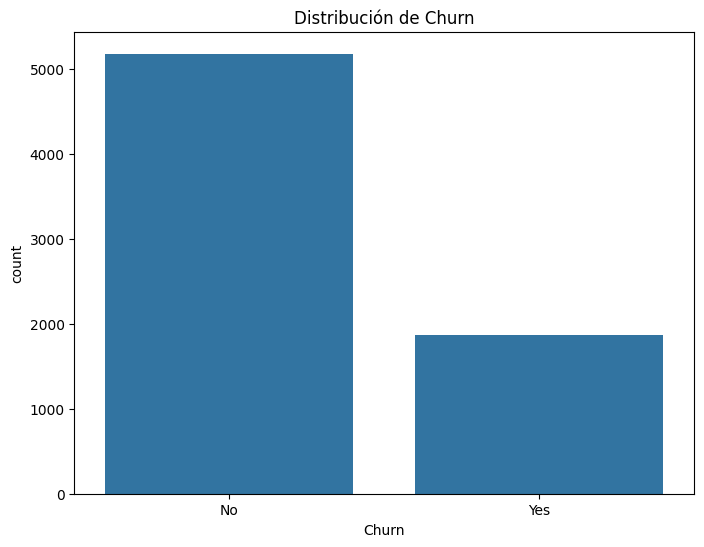

In [4]:
# Distribución de Clases:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Churn')
plt.title('Distribución de Churn')
plt.show()


Variables Categóricas:

Distribución de gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64


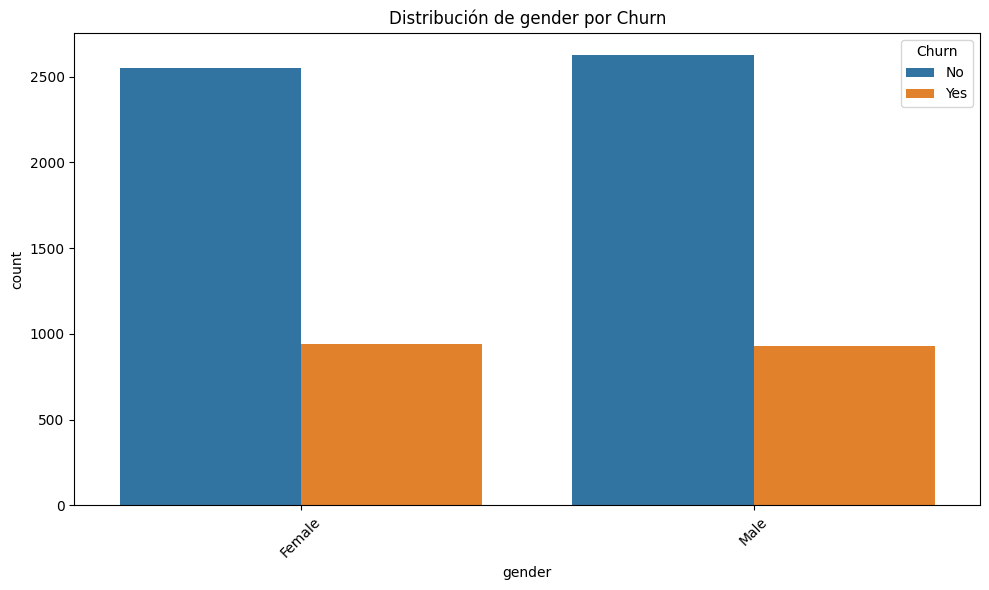


Distribución de Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64


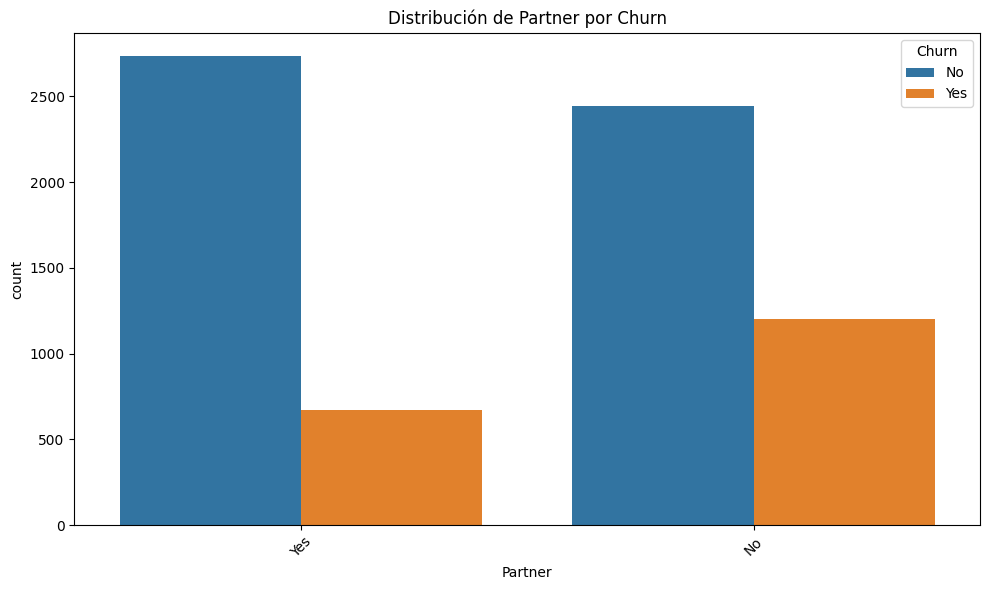


Distribución de Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


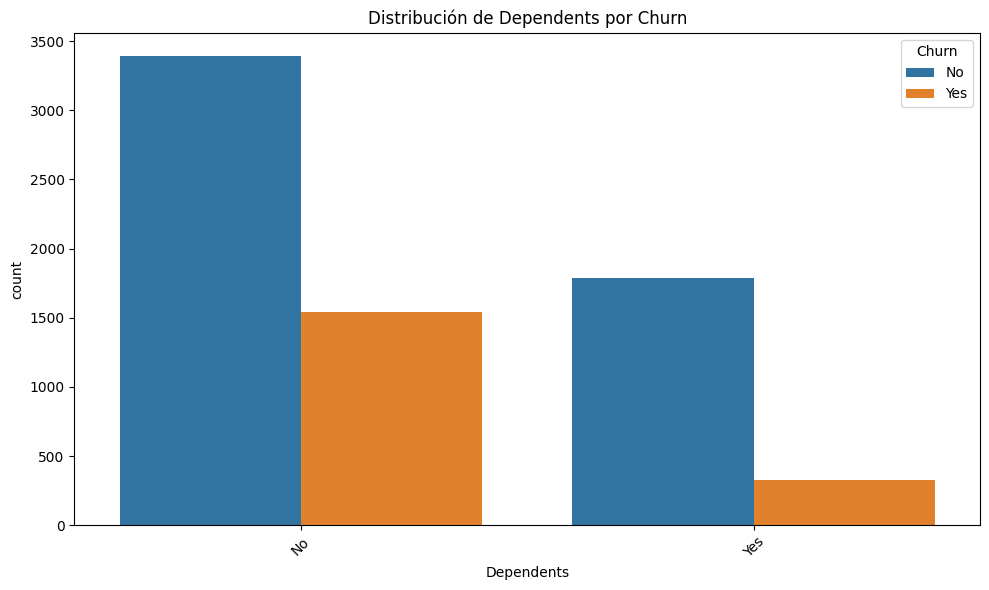


Distribución de PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64


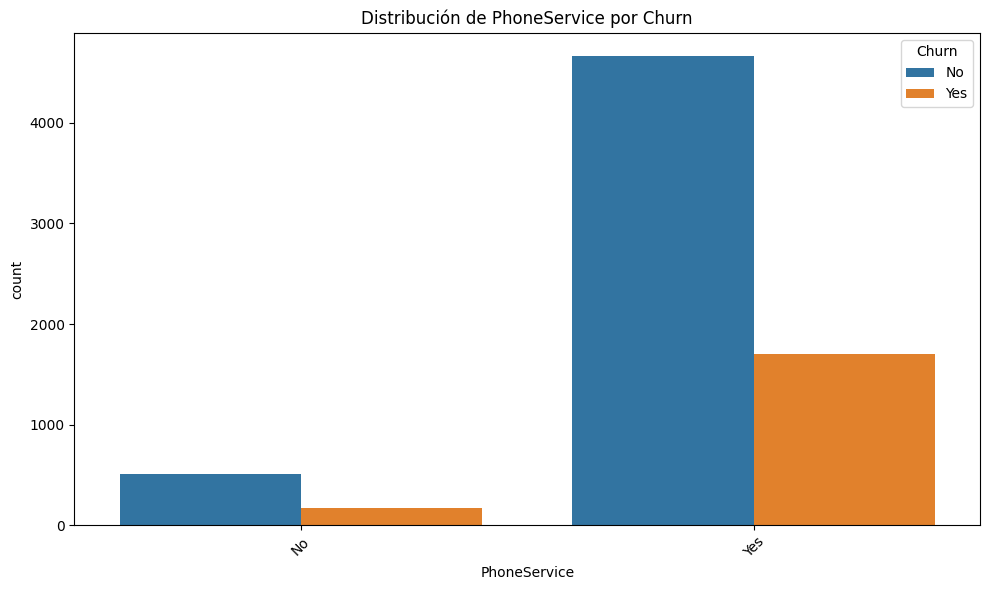


Distribución de MultipleLines:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


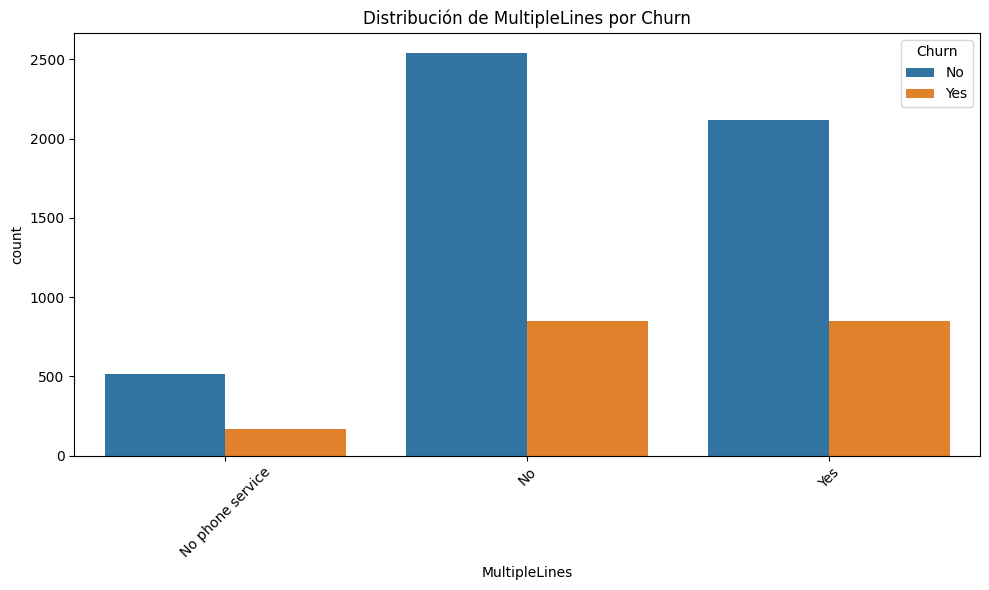


Distribución de InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


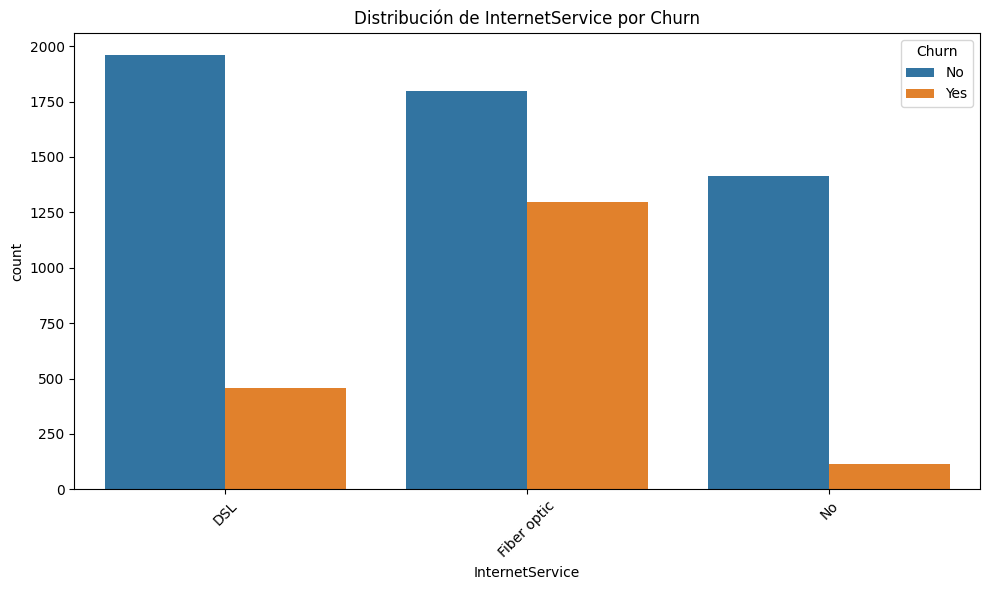


Distribución de OnlineSecurity:
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


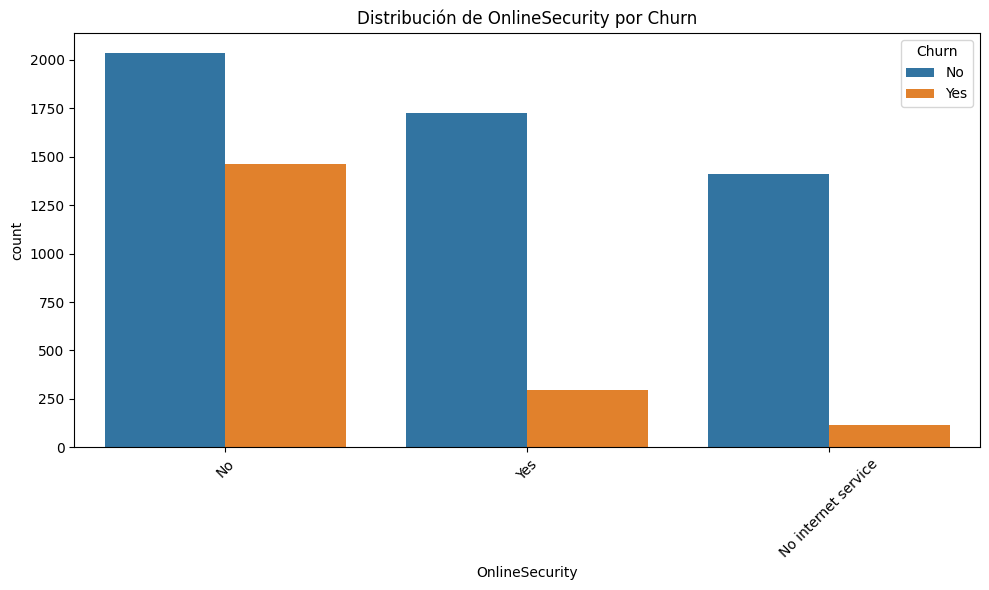


Distribución de OnlineBackup:
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


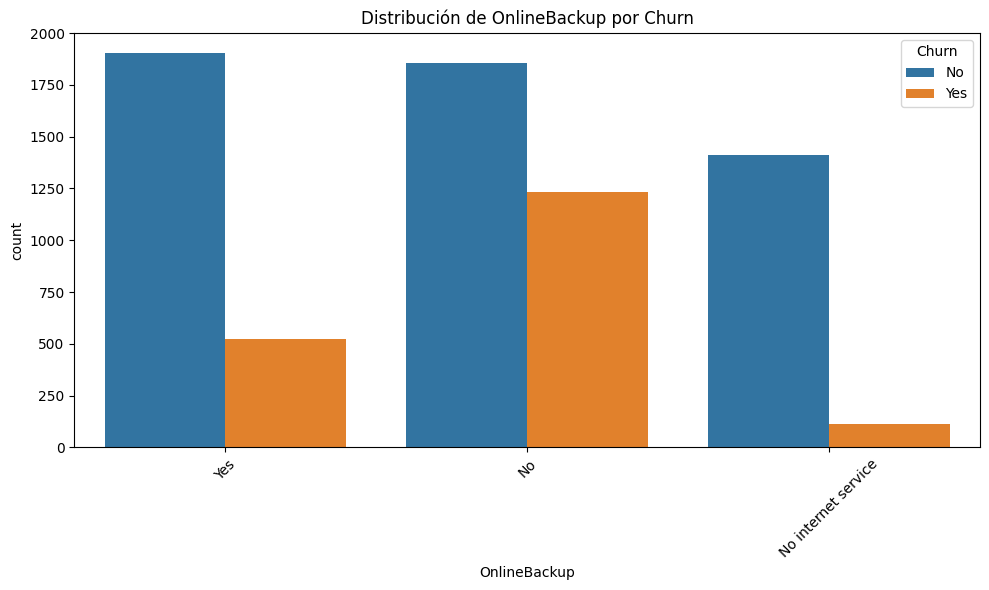


Distribución de DeviceProtection:
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


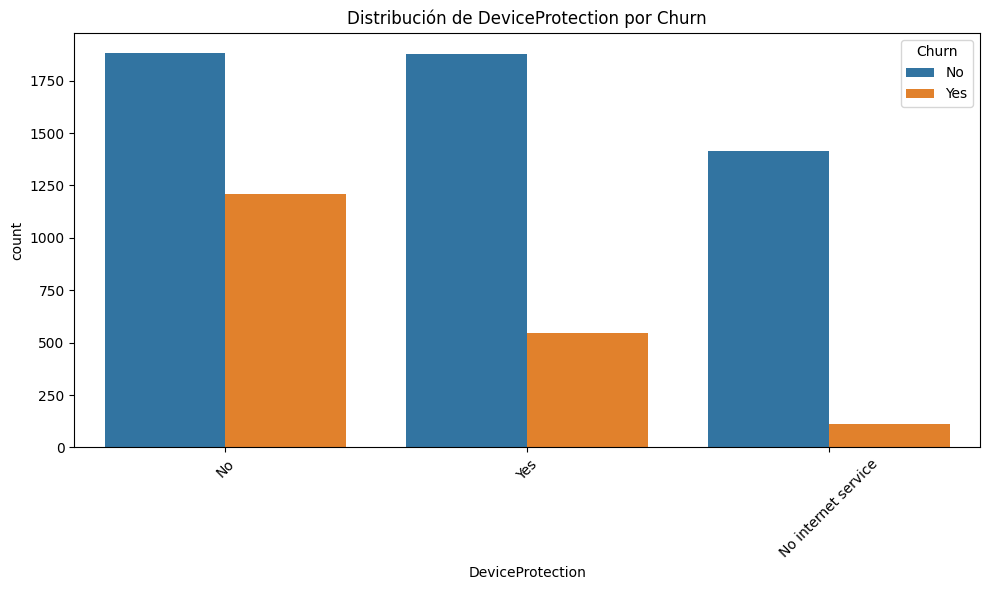


Distribución de TechSupport:
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


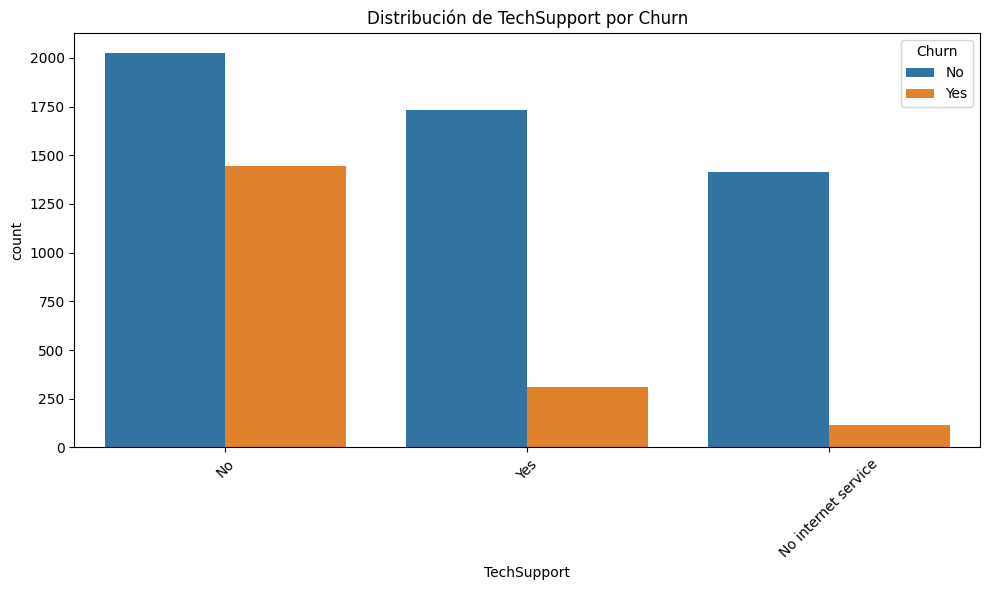


Distribución de StreamingTV:
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


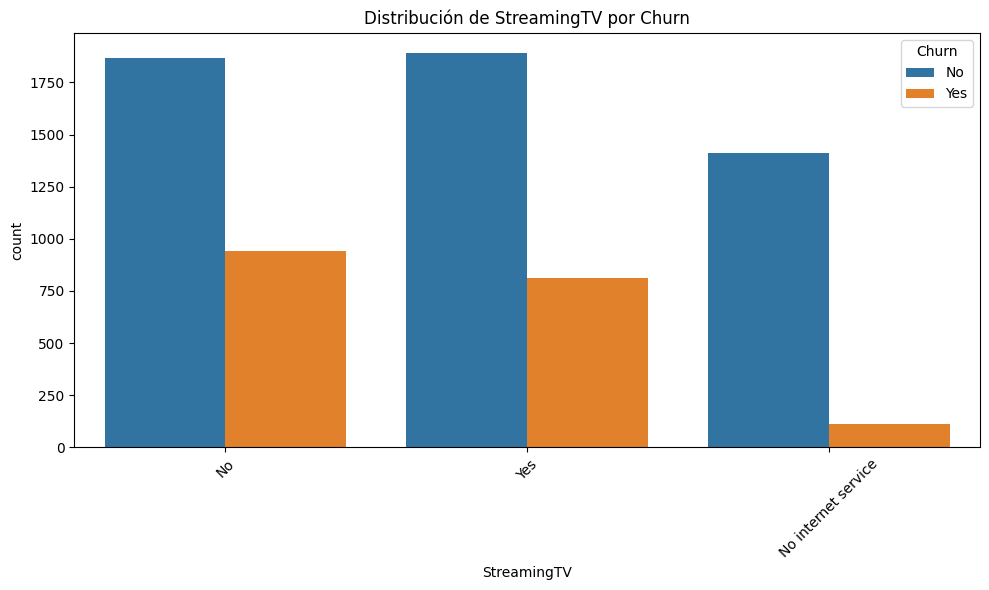


Distribución de StreamingMovies:
StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


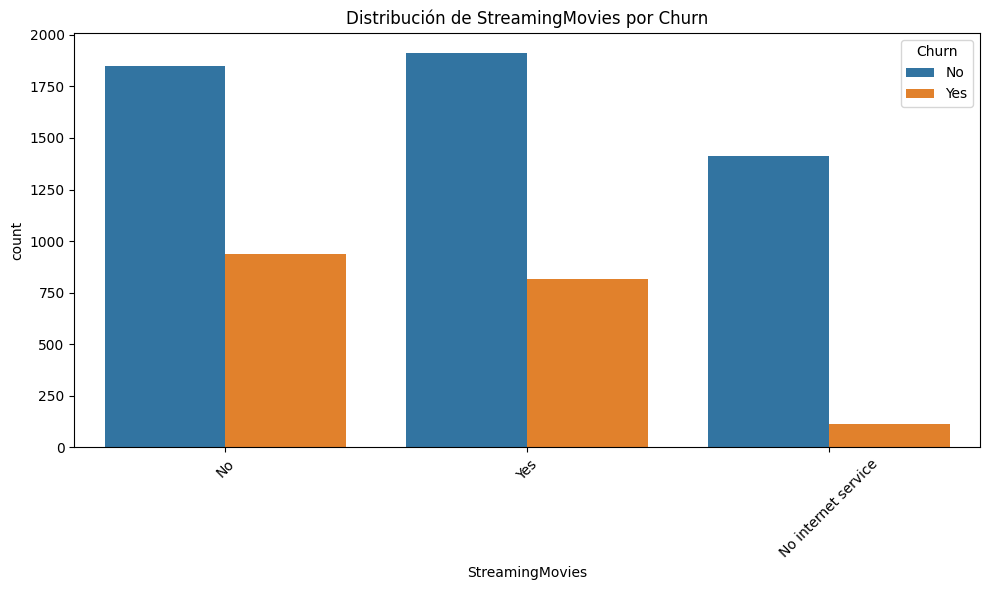


Distribución de Contract:
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


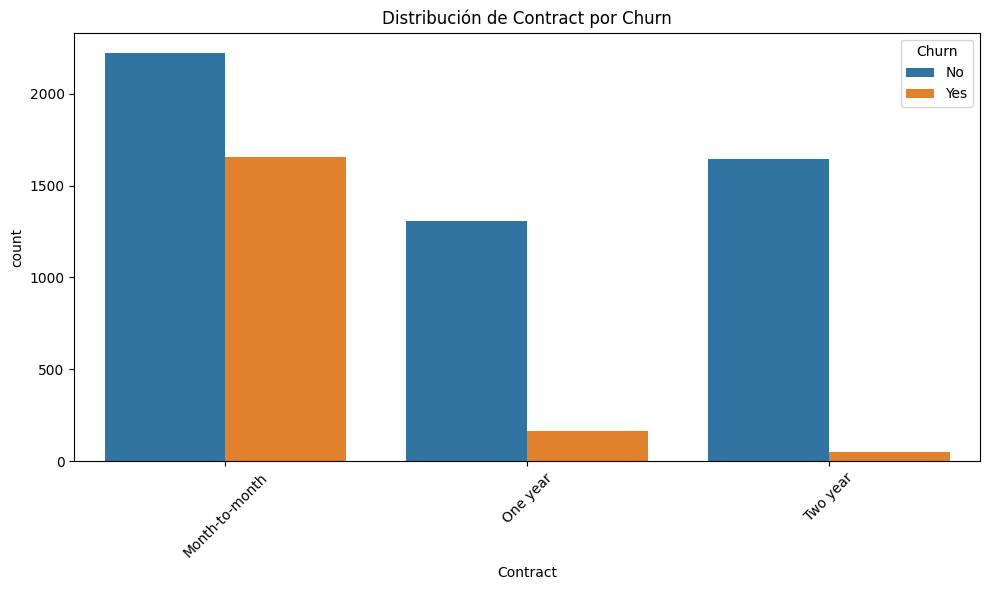


Distribución de PaperlessBilling:
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


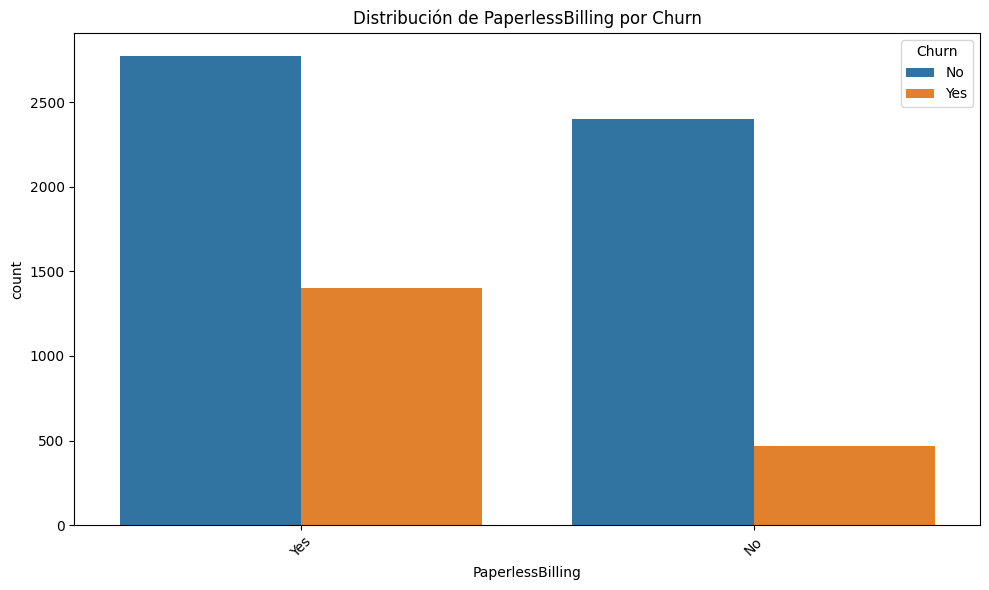


Distribución de PaymentMethod:
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


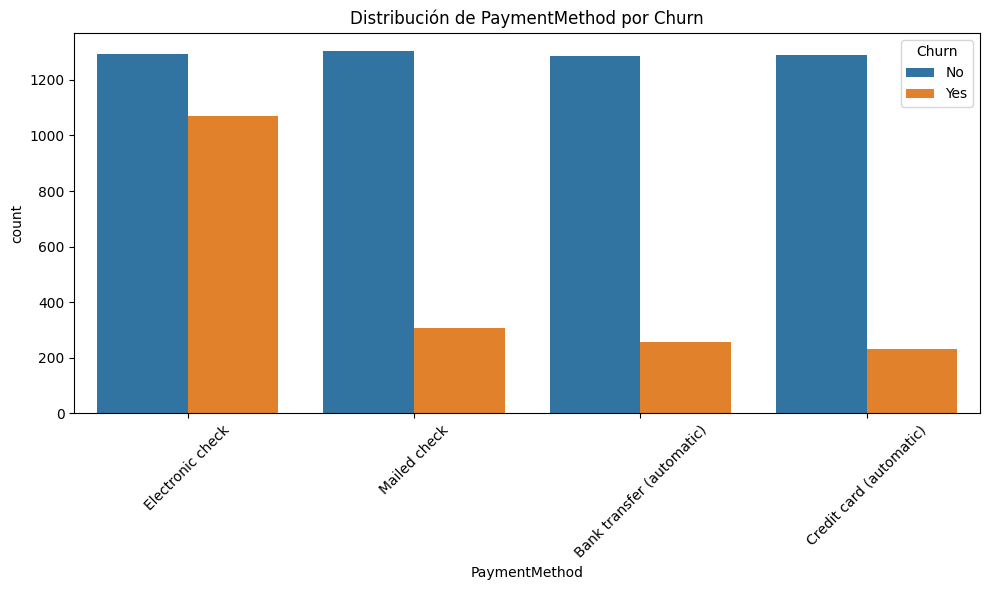


Distribución de TotalCharges:
TotalCharges
           11
20.2       11
19.75       9
20.05       8
19.9        8
           ..
130.15      1
3211.9      1
7843.55     1
2196.3      1
197.4       1
Name: count, Length: 6531, dtype: int64


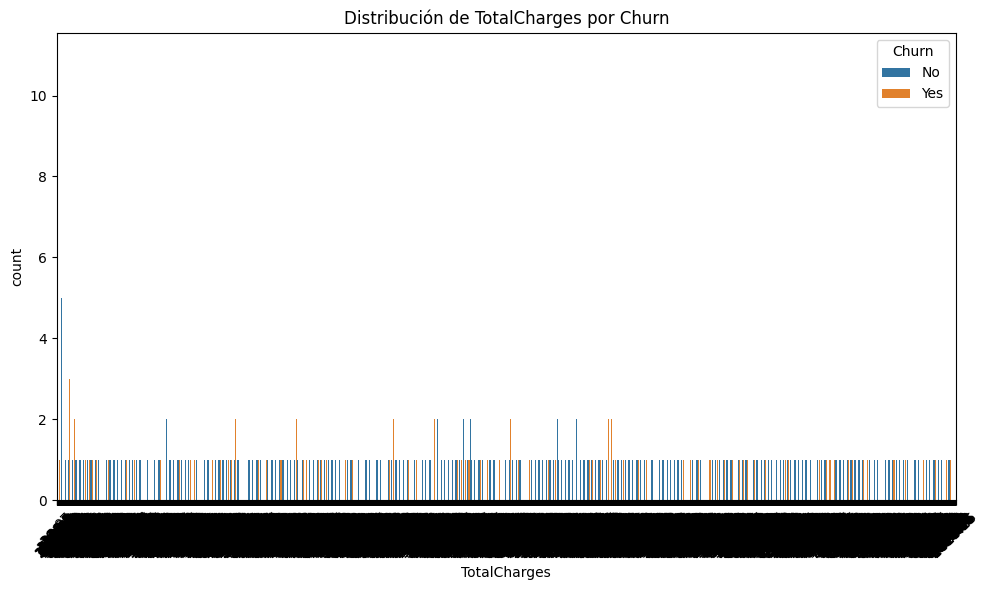


Distribución de Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


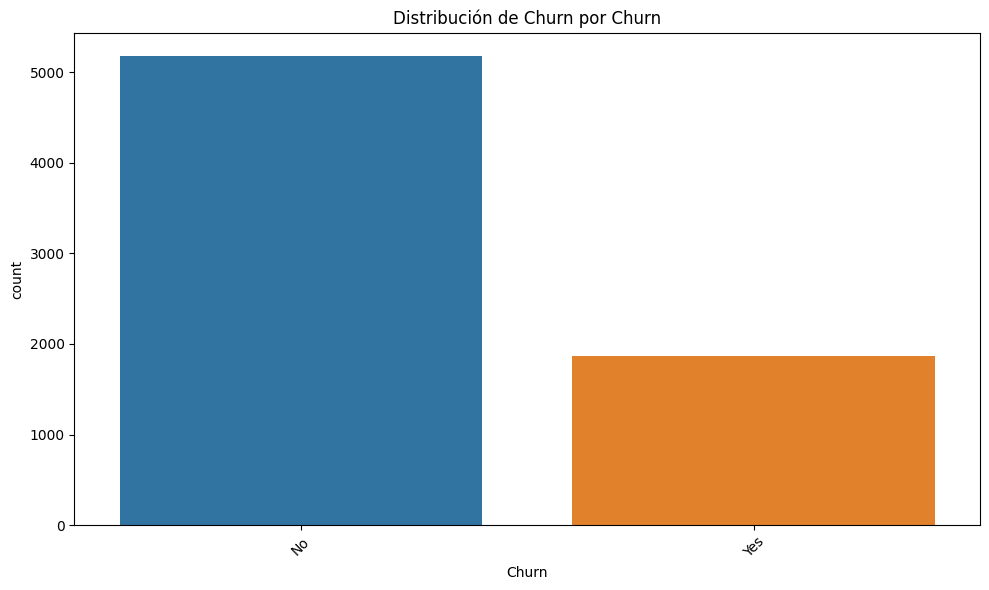

In [5]:
# Análisis de Variables Categóricas:
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nVariables Categóricas:")
for col in categorical_columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        print(df[col].value_counts())

        # Visualización
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue='Churn')
        plt.title(f'Distribución de {col} por Churn')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

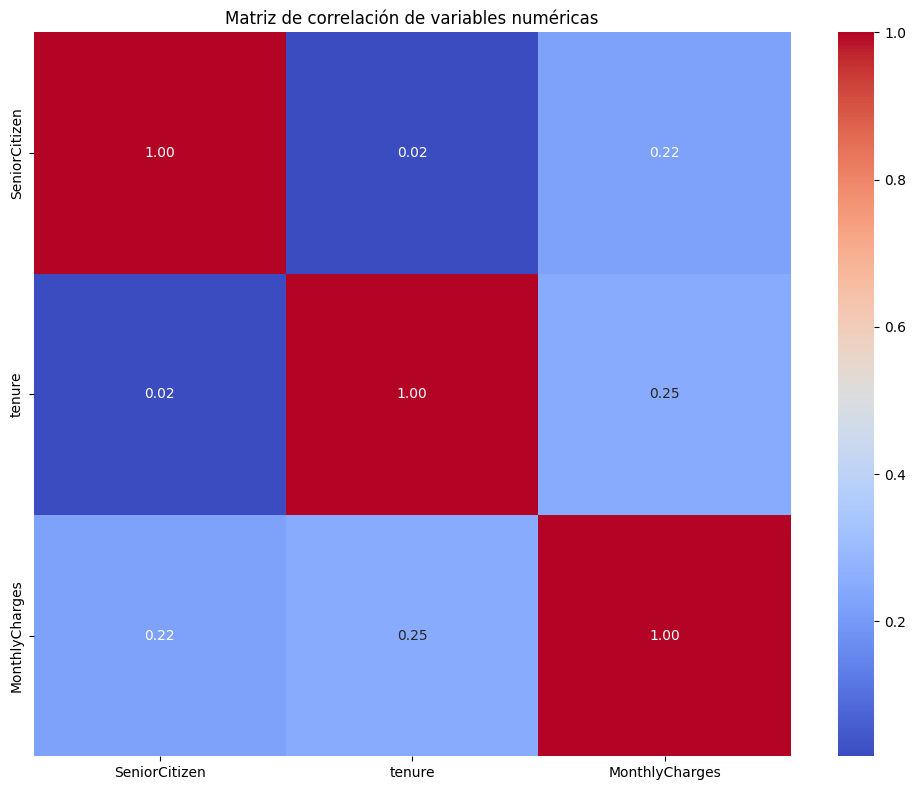

In [6]:
# Correlación entre Variables Numéricas:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Matriz de correlación de variables numéricas")
plt.tight_layout()
plt.show()

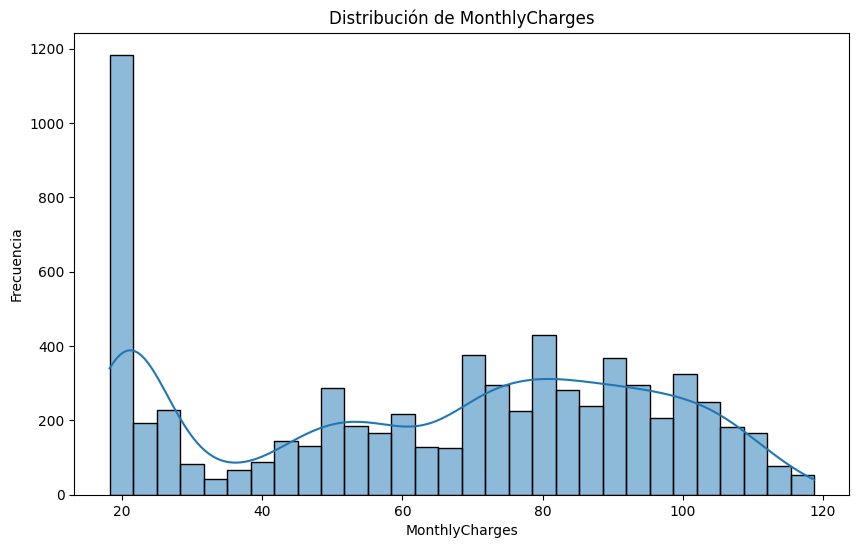


Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [7]:
# Histograma de Ingresos:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', bins=30, kde=True)
plt.title('Distribución de MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frecuencia')
plt.show()

# Información adicional sobre el dataset
print("\nInformación del Dataset:")
print(df.info())

# Valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

## Preparación de Datos

### Normalización.

Normalicé las columnas numéricas (tenure, MonthlyCharges, y TotalCharges) utilizando StandardScaler de scikit-learn, que estandariza los datos para que tengan una media de 0 y una desviación estándar de 1.

**Justificación:**

* Usé StandardScaler porque KNN es sensible a las escalas de las variables.
* Rellené valores faltantes en TotalCharges con la mediana para evitar problemas durante la normalización.
* Solo normalicé las columnas numéricas, ya que las categóricas serán codificadas más adelante.

In [8]:
## Normalización:
from sklearn.preprocessing import StandardScaler

# Convertir 'TotalCharges' a numérico (puede contener valores no numéricos)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Rellenar valores faltantes en 'TotalCharges' con la mediana
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Seleccionar columnas numéricas para normalizar
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Normalizar las columnas numéricas
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("Datos normalizados:")
print(df[numeric_columns].head())

Datos normalizados:
     tenure  MonthlyCharges  TotalCharges
0 -1.277445       -1.160323     -0.994242
1  0.066327       -0.259629     -0.173244
2 -1.236724       -0.362660     -0.959674
3  0.514251       -0.746535     -0.194766
4 -1.236724        0.197365     -0.940470


### División de Datos en Entrenamiento y Prueba

Dividí los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo. Usaré un 80% de los datos para entrenamiento y un 20% para prueba.

**Justificación:**

* Usé train_test_split para dividir los datos de manera aleatoria.
* Codifiqué las variables categóricas con pd.get_dummies para que sean compatibles con el modelo.
* La proporción 80/20 es estándar para garantizar un buen balance entre entrenamiento y evaluación.

In [9]:
from sklearn.model_selection import train_test_split

# Codificar la columna objetivo 'Churn' como binaria
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Eliminar columnas irrelevantes como 'customerID'
df = df.drop(['customerID'], axis=1)

# Codificar variables categóricas con one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar características (X) y variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (5634, 30)
Tamaño del conjunto de prueba: (1409, 30)


## Implementación de KNN

### Importar Biblioteca

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Entrenamiento del Modelo

Entrenaré el modelo KNN con un número inicial de vecinos (n_neighbors=5).

In [11]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Crear el modelo KNN
knn = KNeighborsClassifier()

# Definir el rango de vecinos a probar
param_grid = {'n_neighbors': range(1, 21)}

# Usar GridSearchCV para encontrar el mejor número de vecinos
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejor número de vecinos
best_k = grid_search.best_params_['n_neighbors']
print(f"Mejor número de vecinos: {best_k}")

# Entrenar el modelo con el mejor número de vecinos
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluar el modelo
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo con {best_k} vecinos: {accuracy}")

Mejor número de vecinos: 18
Precisión del modelo con 18 vecinos: 0.8112136266855926


### Predicción y Evaluación de Precisión

Evaluaré el modelo utilizando el conjunto de prueba y calcularé la precisión. También generaré un informe de clasificación y una matriz de confusión para analizar el rendimiento.

Precisión del modelo: 0.8112

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



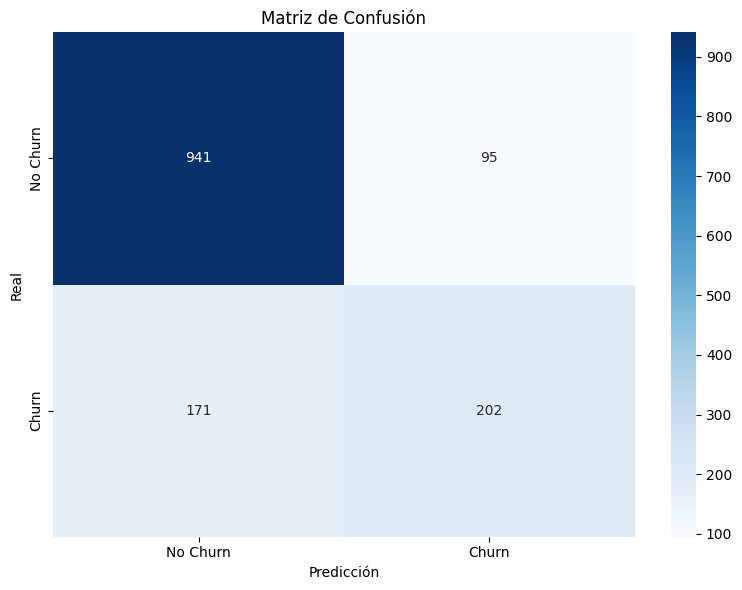

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Realizar predicciones
y_pred = knn.predict(X_test)

# Evaluar precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión con visualización
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### Visualización de Precisión para Diferentes Vecinos

Probaré diferentes valores de n_neighbors para encontrar el número óptimo de vecinos.

**Justificación:**

* Evalué diferentes valores de n_neighbors para encontrar el que maximice la precisión.
* Visualicé los resultados para identificar tendencias y seleccionar el mejor valor.

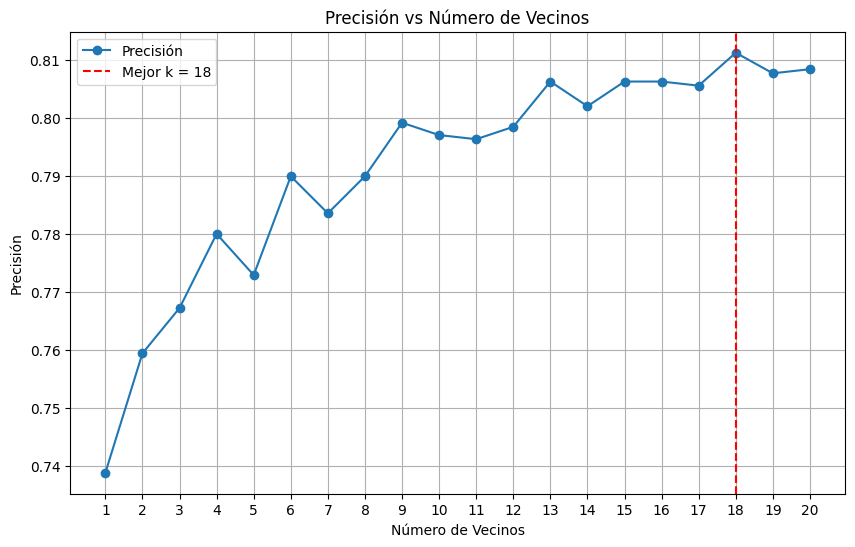

In [13]:
# Probar diferentes valores de n_neighbors
accuracies = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), accuracies, marker='o', label='Precisión')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Mejor k = {best_k}')
plt.title("Precisión vs Número de Vecinos")
plt.xlabel("Número de Vecinos")
plt.ylabel("Precisión")
plt.xticks(range(1, 21))
plt.legend()
plt.grid()
plt.show()